In [165]:
'''
Title:       Optimale Steuerung und Regelung:
Subttitle:   2. Aufgabe
Author:      Stefan Kaufmann
MaNr.        51867606
Date:        06.06.2023
'''

'\nTitle:       Optimale Steuerung und Regelung:\nSubttitle:   2. Aufgabe\nAuthor:      Stefan Kaufmann\nMaNr.        51867606\nDate:        06.06.2023\n'

# Optimale Steuerung und Regelung
## 2. Übung - Volldiskretisierung
### Stefan Kaufmann - 51867606

In [166]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import casadi as cas
import libop as libop

from scipy.optimize import minimize, approx_fprime
from scipy.linalg import block_diag
from scipy.optimize import minimize, Bounds, LinearConstraint, BFGS, NonlinearConstraint

# 1. Model    
    
$
\dot{X}(t) = f (x(t),u(t)) = 
\begin{bmatrix}
\omega (t) \\
\frac{mga sin{\Theta (t) -d \omega(t) +mau(t) cos{\Theta (t)}}}{J+ma^{2}} \\
v(t) \\
u(t)
\end{bmatrix}
$

In [167]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R


t_end = 2.5
N = 50
t = np.linspace(0,t_end,N)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu


S = np.zeros((nx,nx))
S[2,2] = 5
#S = np.eye(nx)*5

M =np.diag([1,1,0,1])
Q = np.eye(4)
S = np.diag([0,0,5,0])
R = np.array([[0.1]])


In [168]:
# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [169]:
# System dynamic
def System_dynamic(x,u):
    dx = np.zeros(nx)
    dx[0] = x[1]
    dx[1] = (m*g*a*np.sin(x[0])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u

    return dx

In [170]:
# Ableitungen

def dfdx(x,u):    
    A =np.zeros((nx,nx))
    A[0,1] = (m*g*np.cos(x[0])-m*a*np.sin(x[0])*u)/(J+m*a**2)   
    A[1,1] = -d/(J+m*a**2)                                      
    A[2,3] = 1                                                  
    return A

def dfdu(x,u):    
    B = np.zeros((nx,nu))                                        
    B[1,0] = (m*a*np.cos(x[0]))/(J+m*a**2)                        
    B[3,0] = 1                                                    
    return B

# 2. Kostenfunktion   
$
\underset{\mathbf{u(\cdot)},x_{0}} {min}     \qquad   J(u,x_{0}) = \varphi(x(t_{f})) + \int_{t_{0}}^{t{f}} l(x(t),u(t),t) dt   \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \quad \Psi (x(t_{f})) = 0 \\
\qquad \qquad  g(x(t),u(t)) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0  \qquad  u(t) \in [u_{mini}, u_{max}]
$

In [171]:
# Kostenfunktion
l  = lambda x,Q: 1+x.T@Q@x/2
dl = lambda x,Q: Q@x       

def cost(y):
    # y = [x0 u0, x1 u1, ....., xN uN]   mit x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]     
    
    cost_ = y[-nxu:-nu]@S@y[-nxu:-nu]/2    # Endkostenterm 0.5*xSx
    
    for k in range(0,N-1):
        k0 = (k)*nxu      
        k1 = (k+1)*nxu            
        cost_ += (t[k+1]-t[k])/2*( l(y[k0:k0+nxu], block_diag(Q,R))+ l(y[k1:k1+nxu],block_diag(Q,R)) )    #  laufende Kosten  1 + 0.5*(xQx + uRu)
               
    return cost_

def costdx(y):
    # Ableitung der Kosten      
    
    dJdy = np.zeros((nxu*N))
    dJdy[-nxu:] = dl(y[-nxu:],block_diag(S,R*0))   
    for k in range(0,N-1):
        k0 = (k)*nxu      
        k1 = (k+1)*nxu    
        #print(k0,k1)  
        dJdy[k0:k1] = (t[k+1]-t[k])/2*( dl(y[k0:k0+nxu],block_diag(Q,R))+ dl(y[k1:k1+nxu],block_diag(Q,R)) )     
    
    return dJdy

In [172]:
def dcost_num(y):
    # Nummerisch Ableiten 
    return approx_fprime(y, cost, 1e-12)

# 3. Optimierung

### Diskretisierung mittels Trapezregel
$    
y = 
\begin{bmatrix}
x_{0} & u_{0} & x_{1} & u_{1} & \cdots & x_{N} & u_{N}
\end{bmatrix}    \\
A_{eq} =
\begin{bmatrix}
      I &  B & 0 & 0 &\cdots & 0 \\
      I \frac{A dt}{2} &  \frac{B dt}{2} & -I+\frac{A dt}{2} & \frac{B dt}{2} & \cdots & 0 \\
      \vdots & & \ddots & 0&\ddots & 0 \\
      \vdots & & \cdots & 0 &I & 0      
\end{bmatrix}     
 A = 
\begin{bmatrix}
A_{eq}  \\
I
\end{bmatrix}  \quad  
l_{eq} \leq  A \begin{bmatrix} y \\ y\end{bmatrix} \leq  u_{eq}
$


$
l_{eq}=
\begin{bmatrix}
-x_{0} & 0
\end{bmatrix}  \quad 
l_{ineq}=
\begin{bmatrix}
x_{min} & u_{min}
\end{bmatrix}  \quad 
l=
\begin{bmatrix}
l_{eq} & l_{ineq}
\end{bmatrix}
$   
$
u_{eq}=
\begin{bmatrix}
-x_{0} & 0
\end{bmatrix}  \quad 
u_{ineq}=
\begin{bmatrix}
x_{max} & u_{max}
\end{bmatrix}  \quad 
u=
\begin{bmatrix}
u_{eq} & u_{ineq}
\end{bmatrix}
$


In [173]:
global x0, xN

# Boundary Conditions
x0 = [np.pi/2,1e-5,-0.5,0]
xN = [0,0,0,0]

xmin = np.array([-np.inf, -np.inf, -0.8, -np.inf])
xmax = np.array([np.inf, np.inf, 0.8, np.inf])
umin = np.array([-12])
umax = np.array([12])


# System Dynamik Constraints  --> lb <= Ay  <= ub
leq = np.hstack([x0, np.zeros((N-2)*(nx)), M@xN])
leq[-2] = -np.inf   # State 3 is not constraint at the Endpoint
ueq = np.hstack([x0, np.zeros((N-2)*(nx)), M@xN])
ueq[-2] = np.inf    # State 3 is not constraint at the Endpoint
print('Die Systembeschränkungen haben eine länge von N*nx = ', N*nx ,' Kontrolle: ', len(leq))

# Diskretisierung mittels Trapezregel:  x(k+1) = [t(k+1)-t(k)]*[f(k+1)-f(k)]/2
def nonlinear_constraint(y):
    con = np.zeros(nx*N)
    con[:nx] = y[:nx]     # Startwert
    con[-nx:] = y[-nx:]   # Endwert
    for k in range(1,N-1):
        k1 = k+1
        dt = t[k+1]-t[k]
        x  = y[k*nxu:k1*nxu-nu]
        x1 = y[k1*nxu:(k1+1)*nxu-nu]
        u  = y[k*nxu+nx:k1*nxu]
        u1 = y[k1*nxu+nx:(k1+1)*nxu]        
        con[k*nx:k1*nx] =  x + dt*(System_dynamic(x,u)+System_dynamic(x1,u1))/2 - x1

    return con



# Linear Constraints -->       lb <= Ay  <= ub
# lineq : [x0,u0, x1,u1, ......, xN,uN]
lineq = np.kron(np.ones(N), np.hstack([xmin, umin]))
uineq =  np.kron(np.ones(N), np.hstack([xmax, umax]))
Aineq = np.eye(N*(nx+nu))



# Startwerte
y0 = np.hstack([x0,0, np.zeros((N-2)*(nx+nu)), M@xN,0])

Die Systembeschränkungen haben eine länge von N*nx =  200  Kontrolle:  200


In [174]:
# Bounds  --> x, u
bounds = Bounds(leq, ueq)

# Equality Constraints
linear_constraint = LinearConstraint(Aineq,lineq, uineq)
non_linear_constr = NonlinearConstraint( nonlinear_constraint, leq, ueq)


res = minimize(cost, y0, method='SLSQP', jac=dcost_num,
               constraints=[non_linear_constr, linear_constraint ], options={'ftol': 1e-9 , 'disp': True})

X1 = res.x

/home/stefan/.local/lib/python3.10/site-packages/scipy/optimize/_constraints.py:479: OptimizeWarning: At least one constraint is unbounded above and below. Such constraints are ignored.
  warn("At least one constraint is unbounded above and below. Such "


Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.5347265548499793
            Iterations: 42
            Function evaluations: 79
            Gradient evaluations: 42


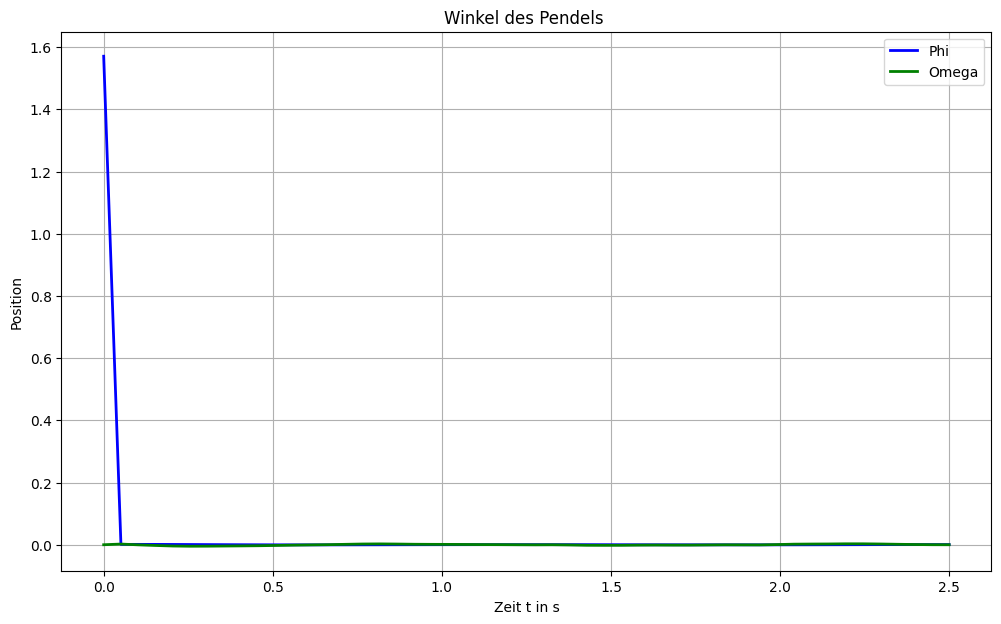

In [175]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Position')
plt.grid()
plt.plot(t,X1[0::nxu],'b', linewidth ='2', label = 'Phi')
plt.plot(t,X1[1::nxu],'g', linewidth ='2', label = 'Omega')

plt.title('Winkel des Pendels ')   
plt.legend(loc = 'best')
plt.show()

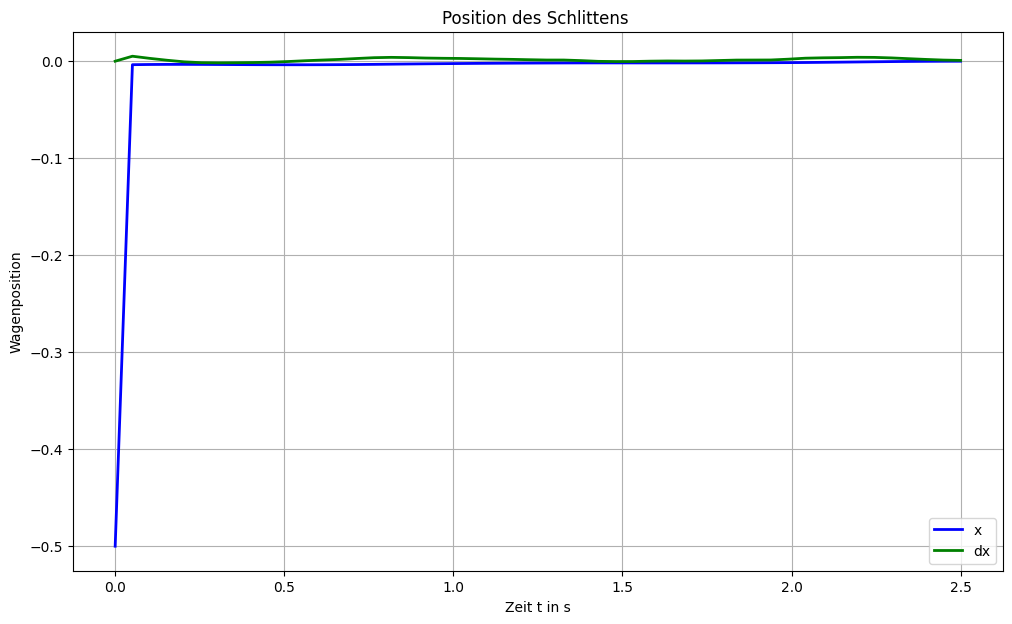

In [176]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Wagenposition')
plt.grid()
plt.plot(t,X1[2::nxu],'b', linewidth ='2', label = 'x')
plt.plot(t,X1[3::nxu],'g', linewidth ='2', label = 'dx')

plt.title('Position des Schlittens ')   
plt.legend(loc = 'best')
plt.show()

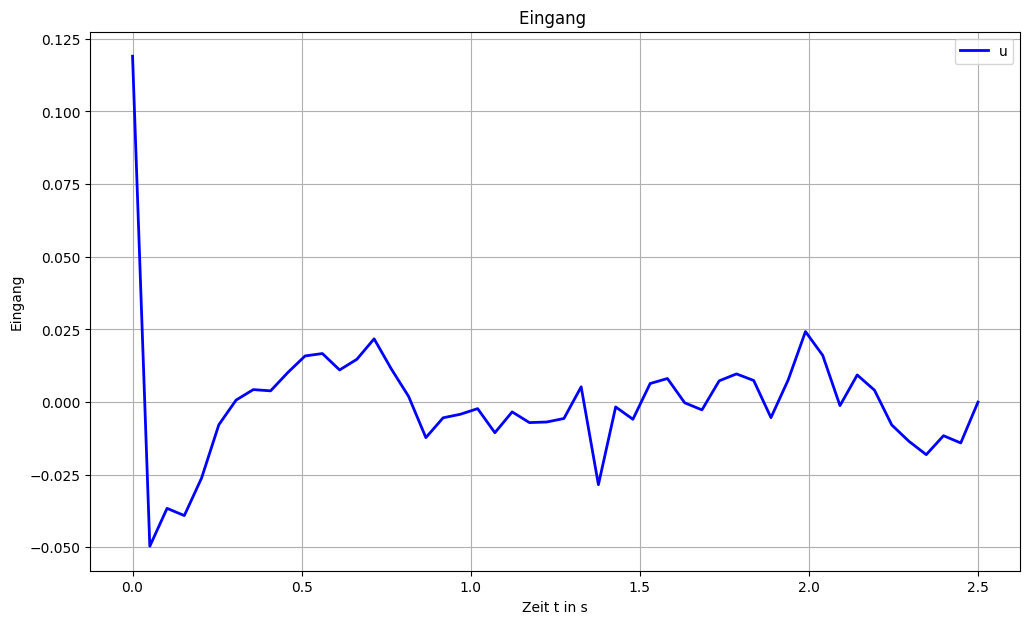

In [177]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Eingang')
plt.grid()
plt.plot(t,X1[4::nxu],'b', linewidth ='2', label = 'u')


plt.title('Eingang ')   
plt.legend(loc = 'best')
plt.show()

# Überprüfung

In [187]:
import control as ct


def system_update(t, x, u,params):
    # Return the derivative of the state
    return System_dynamic(x,u)

def system_output(t, x, u,params):
    return x

# Define the vehicle steering dynamics as an input/output system
Pendel = ct.NonlinearIOSystem(
    system_update, system_output, states=4, name='Quanser',
    inputs=('u'), outputs=('phi','omega','x','dx'))


input = X1[4::nxu] ;  timepts = t


resp = ct.input_output_response(
    Pendel, timepts, input, x0,
    t_eval=t)
t_sim, y_sim, u_sim = resp.time, resp.outputs, resp.inputs


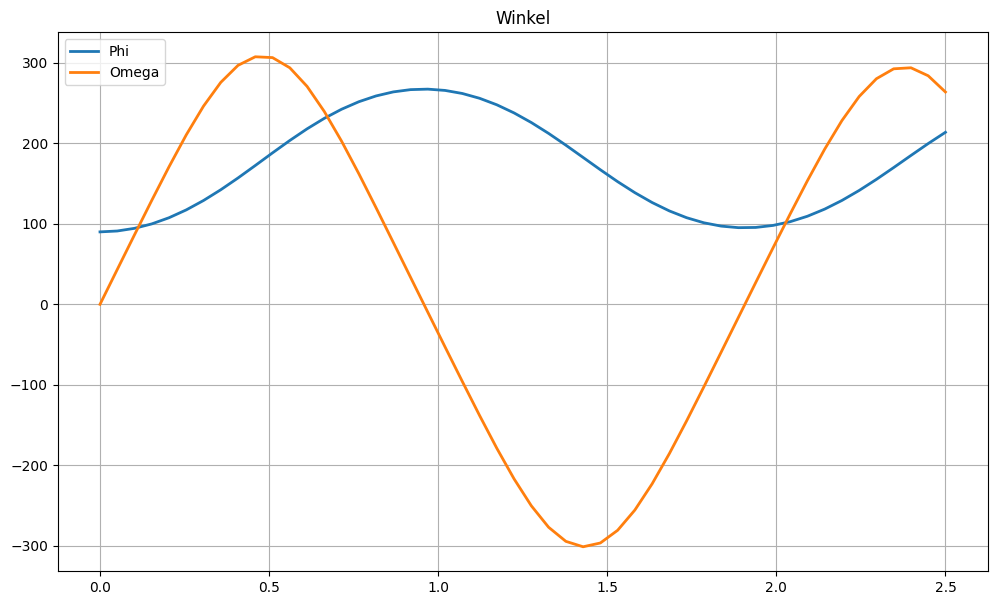

In [188]:
plt.figure(figsize=(12,7))
plt.figure(1)
#plt.plot(t_sim, y_sim[0])
plt.plot(t_sim, y_sim[0]*180/np.pi, linewidth ='2', label = 'Phi')
plt.plot(t_sim, y_sim[1]*180/np.pi, linewidth ='2', label = 'Omega')
#plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Winkel')
plt.legend(loc = 'best')

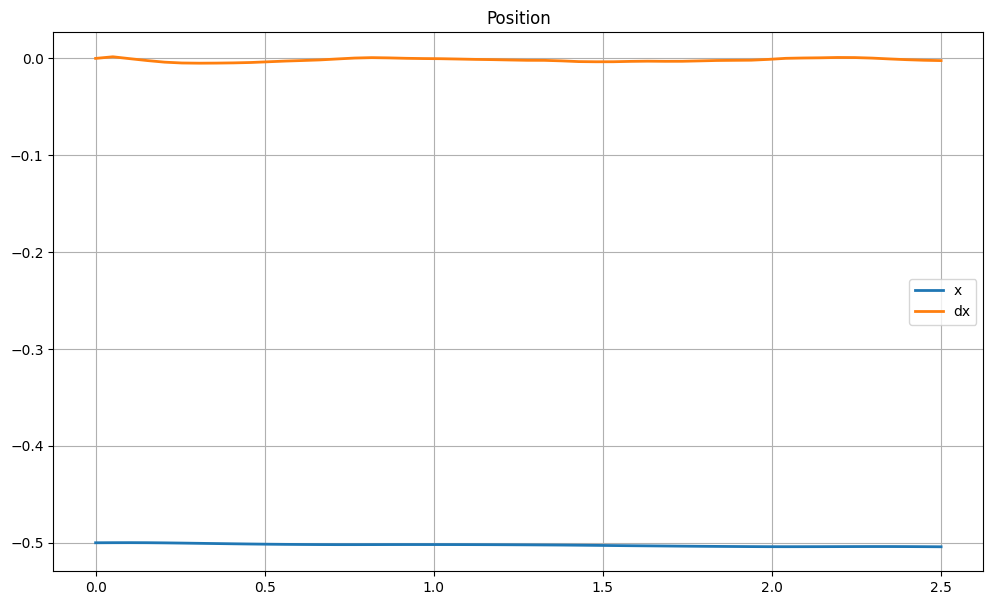

In [192]:
plt.figure(figsize=(12,7))
plt.figure(1)
plt.plot(t_sim, y_sim[2], linewidth ='2', label = 'x')
plt.plot(t_sim, y_sim[3], linewidth ='2', label = 'dx')
#plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Position')
plt.legend(loc = 'best')

ValueError: x and y must have same first dimension, but have shapes (50,) and (1, 50)

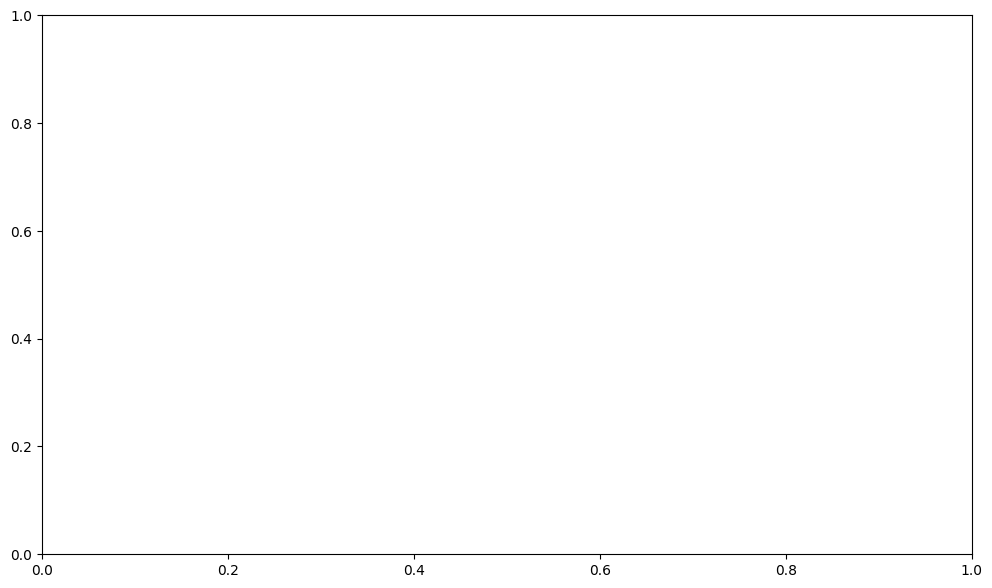

In [193]:
plt.figure(figsize=(12,7))
plt.figure(1)
plt.plot(t_sim, u_sim, linewidth ='2', label = 'U')
#plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Eingang')
plt.legend(loc = 'best')